In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# creating a list of names
words = open('names.txt' , 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
# building the dictionaries like before

chars = sorted(list(set(''.join(words))))
stoi = {s : i+1 for i,s  in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
    

In [5]:
# building the inputs and the outputs for the MLP

block_size = 3 # No. of characters we want to provide as context

X = []
Y = []
num =0
for w in words :
    context = [0] * block_size
    
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print (''.join(itos[i] for i in context), '-->' , itos[ix] )
        context = context[1:] + [ix]
        num += 1
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
g = torch.Generator().manual_seed(2147483647)

In [7]:
X.shape , X.dtype , Y.shape , Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
# Creating the embedding matrix 

C = torch.randn(27, 5 , generator = g)
C[:3]

tensor([[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859],
        [-0.0296, -1.5471,  0.6049,  0.0791,  0.9046],
        [-0.4713,  0.7868, -0.3284, -0.4330,  1.3729]])

In [9]:
emb = C[X]
emb.shape # Eg: [0 , 0 , 0] here gets the first row assigned to each of these ; so 3,2 and 32 such inputs.

torch.Size([228146, 3, 5])

In [21]:
# Second layer with 100 neurons
W1 = torch.randn(15,1000 ,generator = g)
b1 = torch.randn(1000 , generator = g)

In [22]:
# Need to concatenate these to matrix multiply 

emb_cat = torch.cat((emb[:,0,:] , emb[:,1,:] , emb[:,2,:]), 1)

# To explain : instead of having [0 0 0] map as [[0.6044 , -0.3516],  we are mapping it as [0.6044 , -0.3516 , 0.6044 , -0.3516 , 0.6044 , -0.3516]
#                                                [0.6044 , -0.3516],
#                                                [0.6044 , -0.3516]]
# and this as you can see makes [3,2] as [6]

emb_cat[:4]

tensor([[ 0.6169,  1.5160, -1.0447, -0.6641, -0.7239, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046, -1.0188, -0.8378, -2.1057, -0.2604, -1.7149],
        [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859,  1.5674, -0.2373, -0.0274,
         -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,  0.0791,  0.9046],
        [-0.0296, -1.5471,  0.6049,  0.0791,  0.9046,  0.1351, -0.2116, -1.0406,
         -1.5367,  0.9374,  1.1224,  0.5964,  0.4585,  0.0540, -1.7400],
        [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859,  1.5674, -0.2373, -0.0274,
         -1.1008,  0.2859,  0.1156,  0.8032,  0.5411, -1.1646,  0.1476]],
       grad_fn=<SliceBackward0>)

In [23]:
# The above method does not generalize so we can try torch.unbind and then concatenate that

emb_unbind = (torch.cat(torch.unbind(emb , 1),1))
emb_unbind[:4]

tensor([[ 0.6169,  1.5160, -1.0447, -0.6641, -0.7239, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046, -1.0188, -0.8378, -2.1057, -0.2604, -1.7149],
        [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859,  1.5674, -0.2373, -0.0274,
         -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,  0.0791,  0.9046],
        [-0.0296, -1.5471,  0.6049,  0.0791,  0.9046,  0.1351, -0.2116, -1.0406,
         -1.5367,  0.9374,  1.1224,  0.5964,  0.4585,  0.0540, -1.7400],
        [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859,  1.5674, -0.2373, -0.0274,
         -1.1008,  0.2859,  0.1156,  0.8032,  0.5411, -1.1646,  0.1476]],
       grad_fn=<SliceBackward0>)

In [24]:
# Both the above methods are not as efficient as using 'view' attribute. This is because of the fact that
# internally pytorch stores the data in a tensor in sort a linear form and therefore when we use view it simply
# uses some attributes to rearrange and output the result ; so new memory is not generated. 

# Incase of the other two methods, new tensors are geenrtaed and hence memory is used and it is not as efficient.

In [25]:
W2 = torch.randn(1000,27 , generator = g)
b2 = torch.rand(27 , generator = g)

parameters = [C , W1 , b1 , W2 , b2]

In [26]:
for p in parameters :
    p.requires_grad = True
    
    
sum(p.nelement() for p in parameters)

43162

In [27]:
# learning rate scheduler 

lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [28]:
num*0.8

182516.80000000002

In [29]:
# train , test, cv split 

n1 = 182516 # (0.8 * num)
n2 = 205331 # (0.9 * num) 

X_train = X[:n1]
Y_train = Y[:n1]


X_cv = X[n1:n2]
Y_cv = Y[n1:n2]

X_test = X[n2:]
Y_test = X[n2:]

In [63]:
# gradient descent 
g = torch.Generator().manual_seed(2147483647)

lri = []
lossi = []
stepi = [] 

for i in range(10000):
    
    
    # creating mini-batches for faster training
    ix = torch.randint(0, X_train.shape[0],(32,))
    
    
    # forward pass    
    emb = C[X_train[ix]]
   
    h = torch.tanh((emb.view(-1,15) @ W1 + b1))

    # Broadcasting rule
    # (32,100)
    # (1,100) --> (32,100) so same vector to each row as intended

    logits = h @ W2 + b2 
    # counts = logits.exp()
    # probs = counts/torch.sum(counts, axis =1 , keepdims = True)
    # loss = -probs[torch.arange(32) , Y].log().mean()
    loss = F.cross_entropy(logits, Y_train[ix]) # Much more efficient forward pass , backward pass and uses a fused kernel
    # no intermediate tensor creation , backward pass is more efficient becuase the grad expressions simplify like
    # seen with tanh in micrograd ; also overcomes the number of digits restriction of a floating point number.
    

    # backward pass 

    for p in parameters:
        p.grad = None

    loss.backward()
    
    lr = 0.001 # found after scheduling
    # lri.append(lr)

    # update

    for p in parameters:
        p.data += -lr * p.grad
        
    
    lossi.append(loss.item()) 
    stepi.append(i)
        

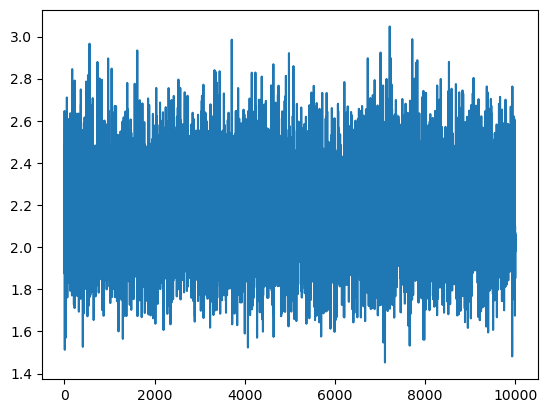

In [64]:
plt.plot(stepi,lossi)

In [65]:
# Training loss on the whole train set 

emb = C[X_train]
h = torch.tanh((emb.view(-1,15) @ W1 + b1))
logits = h @ W2 + b2
loss_train = F.cross_entropy(logits, Y_train)

In [66]:
# Cross-validation loss on the test set 

emb = C[X_cv]
h = torch.tanh((emb.view(-1,15) @ W1 + b1))
logits = h @ W2 + b2
loss_cv = F.cross_entropy(logits, Y_cv)

In [67]:
print (f'Loss on the training set is : {loss_train.item()}')
print (f'Loss on the cross-validation set is : {loss_cv.item()}')

Loss on the training set is : 2.16650652885437
Loss on the cross-validation set is : 2.4306347370147705


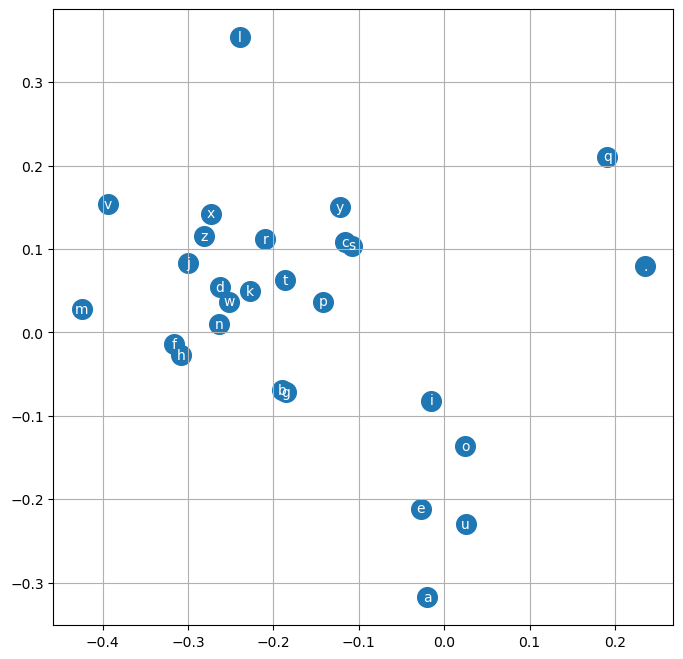

In [68]:
# showing ditribution of characters into 2 dimensions

plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data , C[:,1].data , s=200)
for i in range (C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i] , ha = 'center' , va= 'center' , color = 'white')
plt.grid('minor')
    

In [70]:
# Sampling of the names from this model 

for i in range (10):
    name = []
    context = [0]* block_size
    
    while True:
        
        emb = C[torch.tensor(context)]
        h = torch.tanh((emb.view(-1,15) @ W1 + b1))
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, replacement = True , generator = g ).item()
        
        context = context[1:] + [ix]
        name.append(itos[ix])
        if ix == 0:
            break
    print(''.join(name))      

cex.
maleah.
makilah.
tah.
mellistterin.
lucan.
katha.
samiyah.
javer.
gotai.


In [71]:
# Names seem to be doing better than the first model atleast and from the chart we can see how the vowels
# are clubbed together and the . is separate and also how some of the less commonly replacable words are 
# separated. This follows along the ideas on Bengio et al. 2003 